# <center>Atividade Final</center>

1. Resultados (curvas e Matrizes de confusão) da CNN com Bootstrap

2. Resultados da CNN com Fine tuning  

3. Resultados (curvas e Matrizes de confusão) da CNN com Bootstrap com algum pré-processing.

4. Resultados da CNN com Fine tuning  com algum pré-processing.

5. Relatórios indicando o resultado com  e sem pré-processamento (porém com data augmentation)  usando as mesmas configurações da  da rede. 

Deve haver aumento na  acurácia, ou a prova que mesmo aplicando todos os algoritmos não ouve mudança. 

Algoritmos

1. Operadores Morfológicos.

2. Segmentação 

3. Suavização, Realce, Detecção de Bordas

4. Transformação para Domínio da frequência (não obrigatório).

5. Cornerfeature (não obrigatório)

## Imports

In [111]:
from collections import defaultdict
from pathlib import Path
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil
import zipfile

import keras
from keras.applications.densenet import DenseNet, DenseNet121, DenseNet169, DenseNet201, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, BackupAndRestore
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import skimage as si
from skimage.io import imread, imshow, imsave
from skimage.filters import threshold_otsu
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening,disk)
from skimage.color import rgb2gray

In [112]:
def gridplot(img_list: list,
             cols: int,
             ):
    fig, ax = plt.subplots(nrows=int(-(-len(img_list)//cols)),
                           ncols=cols,
                           figsize=(5*cols, 5*int(-(-len(img_list)//cols))),
                           squeeze=False
                           )
    for i, x in enumerate(img_list):
        ax[i//cols, i%cols].imshow(x)

## Dataset

Extraindo os dados

### Batch size

In [113]:
download_dir = Path('./Dataset')
BATCH_SIZE = 64

In [114]:
with zipfile.ZipFile('Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall(download_dir)

In [115]:
class_subset = sorted(os.listdir(download_dir/'test'))
class_subset

['anabele', 'chris', 'diniz', 'manuela', 'matheus', 'michel', 'pablo']

### Pré-Processamento

#### Morfologia

In [7]:
def pre_opening(x, area_thresh):
    # Opening
    gray = rgb2gray(x[:])
    opened= area_opening(image=gray,
                            area_threshold=area_thresh,
                            )
    tresh = threshold_otsu(image=opened)
    binary = opened < tresh
    x[binary]=0
    return x

In [39]:
def _preprocess_function(x, disk_size):
    gray = rgb2gray(x[:])
    dilated= dilation(image=gray,
                        footprint=disk(disk_size),
                        )
    tresh = threshold_otsu(image=dilated)
    binary = dilated > tresh
    x[binary]=255
    x = preprocess_input(x)    
    return x

In [26]:
def _preprocess_function(x, sigma):
    x = si.filters.gaussian(image=x,
                            sigma=sigma)
    x = preprocess_input(x)
    return x

In [ ]:
def preprocessamento(path):
    image = imread(str(path))
    seg_image = pre_opening(image, 100)
    pre=Path('.PRE')

In [15]:
paths = ['train', 'valid', 'test']
save = Path('./Dataset_open')

for path in paths:
    for class_dir in class_subset:
        image_files = os.listdir(download_dir/path/class_dir)
        for image_file in image_files:
            image_path = download_dir/path/class_dir/image_file
            image = imread(str(image_path))
            seg_image = pre_opening(image, 100)

            # Salvando a imagem
            save_path = save/path/class_dir
            os.makedirs(save_path, exist_ok=True)
            imsave(str(save_path/image_file), seg_image)

In [60]:
pics = []
for file in download_dir.rglob('*.jpg'):
    pics.append(file)

In [85]:
from joblib import Parallel, delayed

def jobloop(pics):
    Parallel(n_jobs=6)(delayed(preprocessamento)(i) for i in pics)

caminho = download_dir

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00495364, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

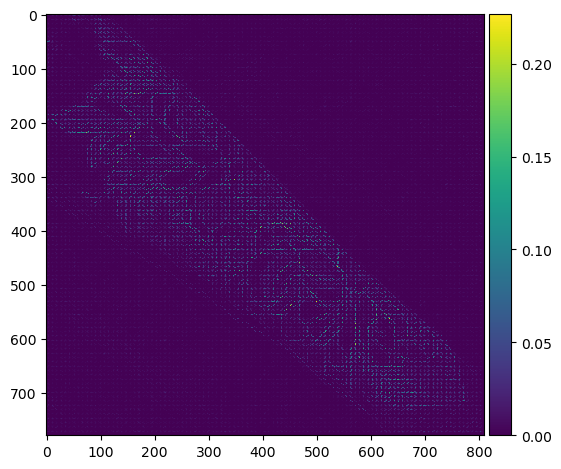

In [99]:
img = imread('.\\Dataset\\test\\anabele\\anabele (6).jpg')
gray = rgb2gray(img)
hog, hogimg = si.feature.hog(gray, visualize=True)
imshow(hogimg)
hogimg

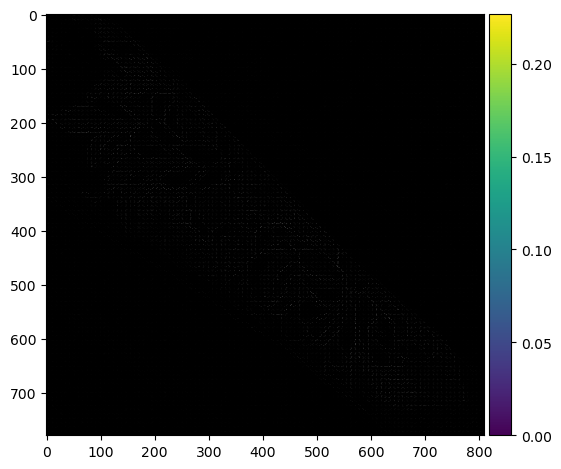

In [108]:
newhog = np.stack([hogimg, hogimg, hogimg], axis=-1)
imshow(newhog[:,:,:])

### Dados de treino e validação

In [116]:
download_dir = '.Dataset_novo'

train_generator = ImageDataGenerator(rotation_range=90,
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     preprocessing_function=preprocess_input,
                                     #preprocessing_function=preprocess,
                                     )

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    #preprocessing_function=preprocess,
                                    )

In [117]:
training = train_generator.flow_from_directory(download_dir/'train',
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validation = train_generator.flow_from_directory(download_dir/'valid',
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testing = test_generator.flow_from_directory(download_dir/'test',
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 1323 images belonging to 7 classes.
Found 345 images belonging to 7 classes.
Found 166 images belonging to 7 classes.


In [ ]:
lista = [x for x in training[0][0]]
gridplot(lista, 4)

## Criação e treinamento do modelo

In [118]:
def create_model(input_shape: tuple,
                 n_classes: int,
                 optimizer: str='rmsprop',
                 fine_tune: int=0,
                 ):
    """
    Compiles a model integrated with Densenet pre-trained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pre-trained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = DenseNet121(include_top=False,
                            weights='imagenet',
                            input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pre-trained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [119]:
input_shape = testing[0][0].shape
optim_1 = Adam(learning_rate=0.001)
n_classes=len(class_subset)

n_steps = training.samples // BATCH_SIZE
n_val_steps = validation.samples // BATCH_SIZE

n_epochs = 35

# First we'll train the model without Fine-tuning
dense_model = create_model(input_shape, n_classes, optim_1, fine_tune=9)

In [120]:
dense_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

### Callbacks do modelo

In [121]:
from livelossplot.inputs.keras import PlotLossesCallback

#path to save models
path = './models/tattoo_2'

# Save model during training
restore = BackupAndRestore(backup_dir=path+"/backup")

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights

tl_checkpoint_1 = ModelCheckpoint(filepath=path+'/tattoo_weights.hdf5',
                                  verbose=1,
                                  save_best_only=True,
                                  #save_weights_only=True
                                  )

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

### Treinamento

In [122]:
#%%time

dense_history = dense_model.fit(training,
                                batch_size=BATCH_SIZE,
                                epochs=n_epochs,
                                validation_data=validation,
                                steps_per_epoch=n_steps,
                                validation_steps=n_val_steps,
                                callbacks=[early_stop,
                                           #plot_loss_1,
                                           #restore, #backup to restore from epoch
                                           #tl_checkpoint_1, #saves weights
                                           ], 
                                verbose=1,
                                workers=8,
                                )

Epoch 1/35
20/20 [==============================] - 27s 555ms/step - loss: 56.6975 - accuracy: 0.2081 - val_loss: 4.4011 - val_accuracy: 0.3219
Epoch 2/35
20/20 [==============================] - 11s 408ms/step - loss: 2.1107 - accuracy: 0.4273 - val_loss: 1.6382 - val_accuracy: 0.4844
Epoch 3/35
20/20 [==============================] - 9s 367ms/step - loss: 1.0130 - accuracy: 0.5949 - val_loss: 1.0090 - val_accuracy: 0.6781
Epoch 4/35
20/20 [==============================] - 10s 391ms/step - loss: 0.8491 - accuracy: 0.6934 - val_loss: 0.7718 - val_accuracy: 0.7219
Epoch 5/35
20/20 [==============================] - 10s 397ms/step - loss: 0.7444 - accuracy: 0.7204 - val_loss: 0.7106 - val_accuracy: 0.7281
Epoch 6/35
20/20 [==============================] - 9s 343ms/step - loss: 0.6596 - accuracy: 0.7450 - val_loss: 0.5915 - val_accuracy: 0.7844
Epoch 7/35
20/20 [==============================] - 8s 310ms/step - loss: 0.6897 - accuracy: 0.7387 - val_loss: 0.5981 - val_accuracy: 0.7625
E

### Salvando pesos da rede e dados do treinamento

In [37]:
path = './models/tattoo_4'

dense_model.save_weights(filepath=path+'/tattoo_weights.hdf5')
pd.DataFrame(dense_history.history).to_csv(path+'/treinamento.csv')

In [40]:
path = './models/tattoo_3'


## Predições
### Importando o modelo treinado

In [53]:
# Generate predictions
dense_imodel = create_model(input_shape, n_classes, optim_1, fine_tune=9)
#dense_imodel = load_model(filepath=path+'/tattoo_weights.hdf5')
dense_imodel.load_weights(filepath=path+'/tattoo_weights.hdf5') # initialize the best trained weights

true_classes = testing.classes

class_indices = training.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

dense_pred_classes = np.argmax(dense_imodel.predict(testing), axis=-1)

166/166 [==============================] - 20s 110ms/step


In [54]:
from sklearn.metrics import accuracy_score

dense_acc = accuracy_score(true_classes, dense_pred_classes)
print("DenseNet Model Accuracy without Fine-Tuning: {:.2f}%".format(dense_acc * 100))

DenseNet Model Accuracy without Fine-Tuning: 77.71%


### Apresentação as estatísticas do treinamento

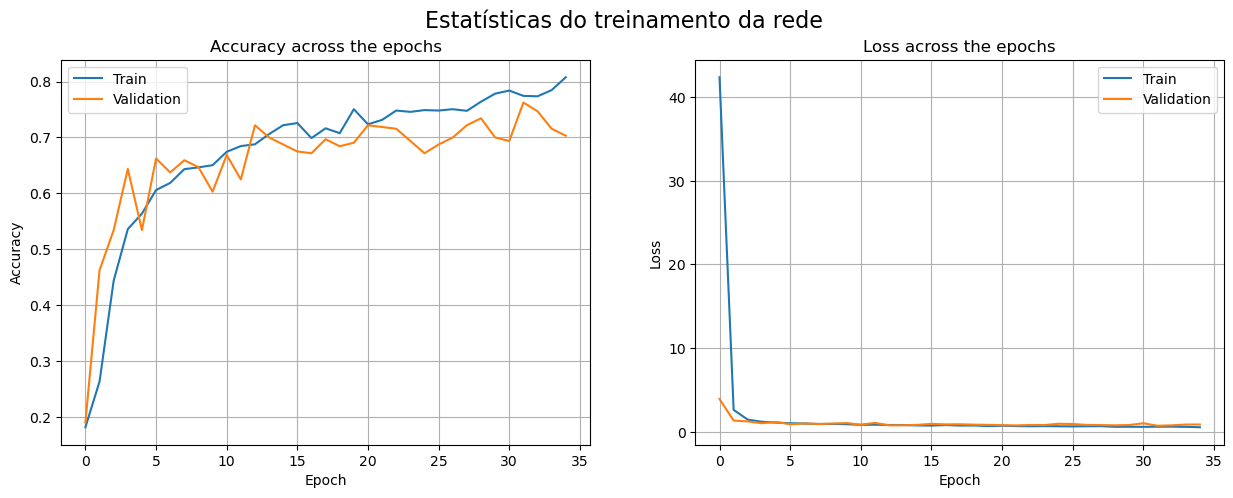

In [49]:
dense_history = pd.read_csv(path+'/treinamento.csv')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(dense_history['accuracy'])
ax[0].plot(dense_history['val_accuracy'])
ax[0].grid(True)
ax[0].legend(['Train' , 'Validation'])
ax[0].set(xlabel='Epoch', ylabel='Accuracy', title='Accuracy across the epochs')
#plt.gca().set_ylim(0,3)

ax[1].plot(dense_history['loss'])
ax[1].plot(dense_history['val_loss'])
ax[1].grid(True)
ax[1].legend(['Train' , 'Validation'])
ax[1].set(xlabel='Epoch', ylabel='Loss', title='Loss across the epochs')

plt.suptitle('Estatísticas do treinamento da rede', fontsize=16)
plt.show()

In [19]:
def display_results(y_true, y_preds, class_labels):

    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)

    results.sort_values(by='F-Score', ascending=False, inplace=True)
    global_acc = accuracy_score(y_true, y_preds)

    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices, size):

    fig = plt.figure(figsize=(20, size))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=size, replace=False)):
        ax = fig.add_subplot(int(size/5), 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]),)
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]

        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

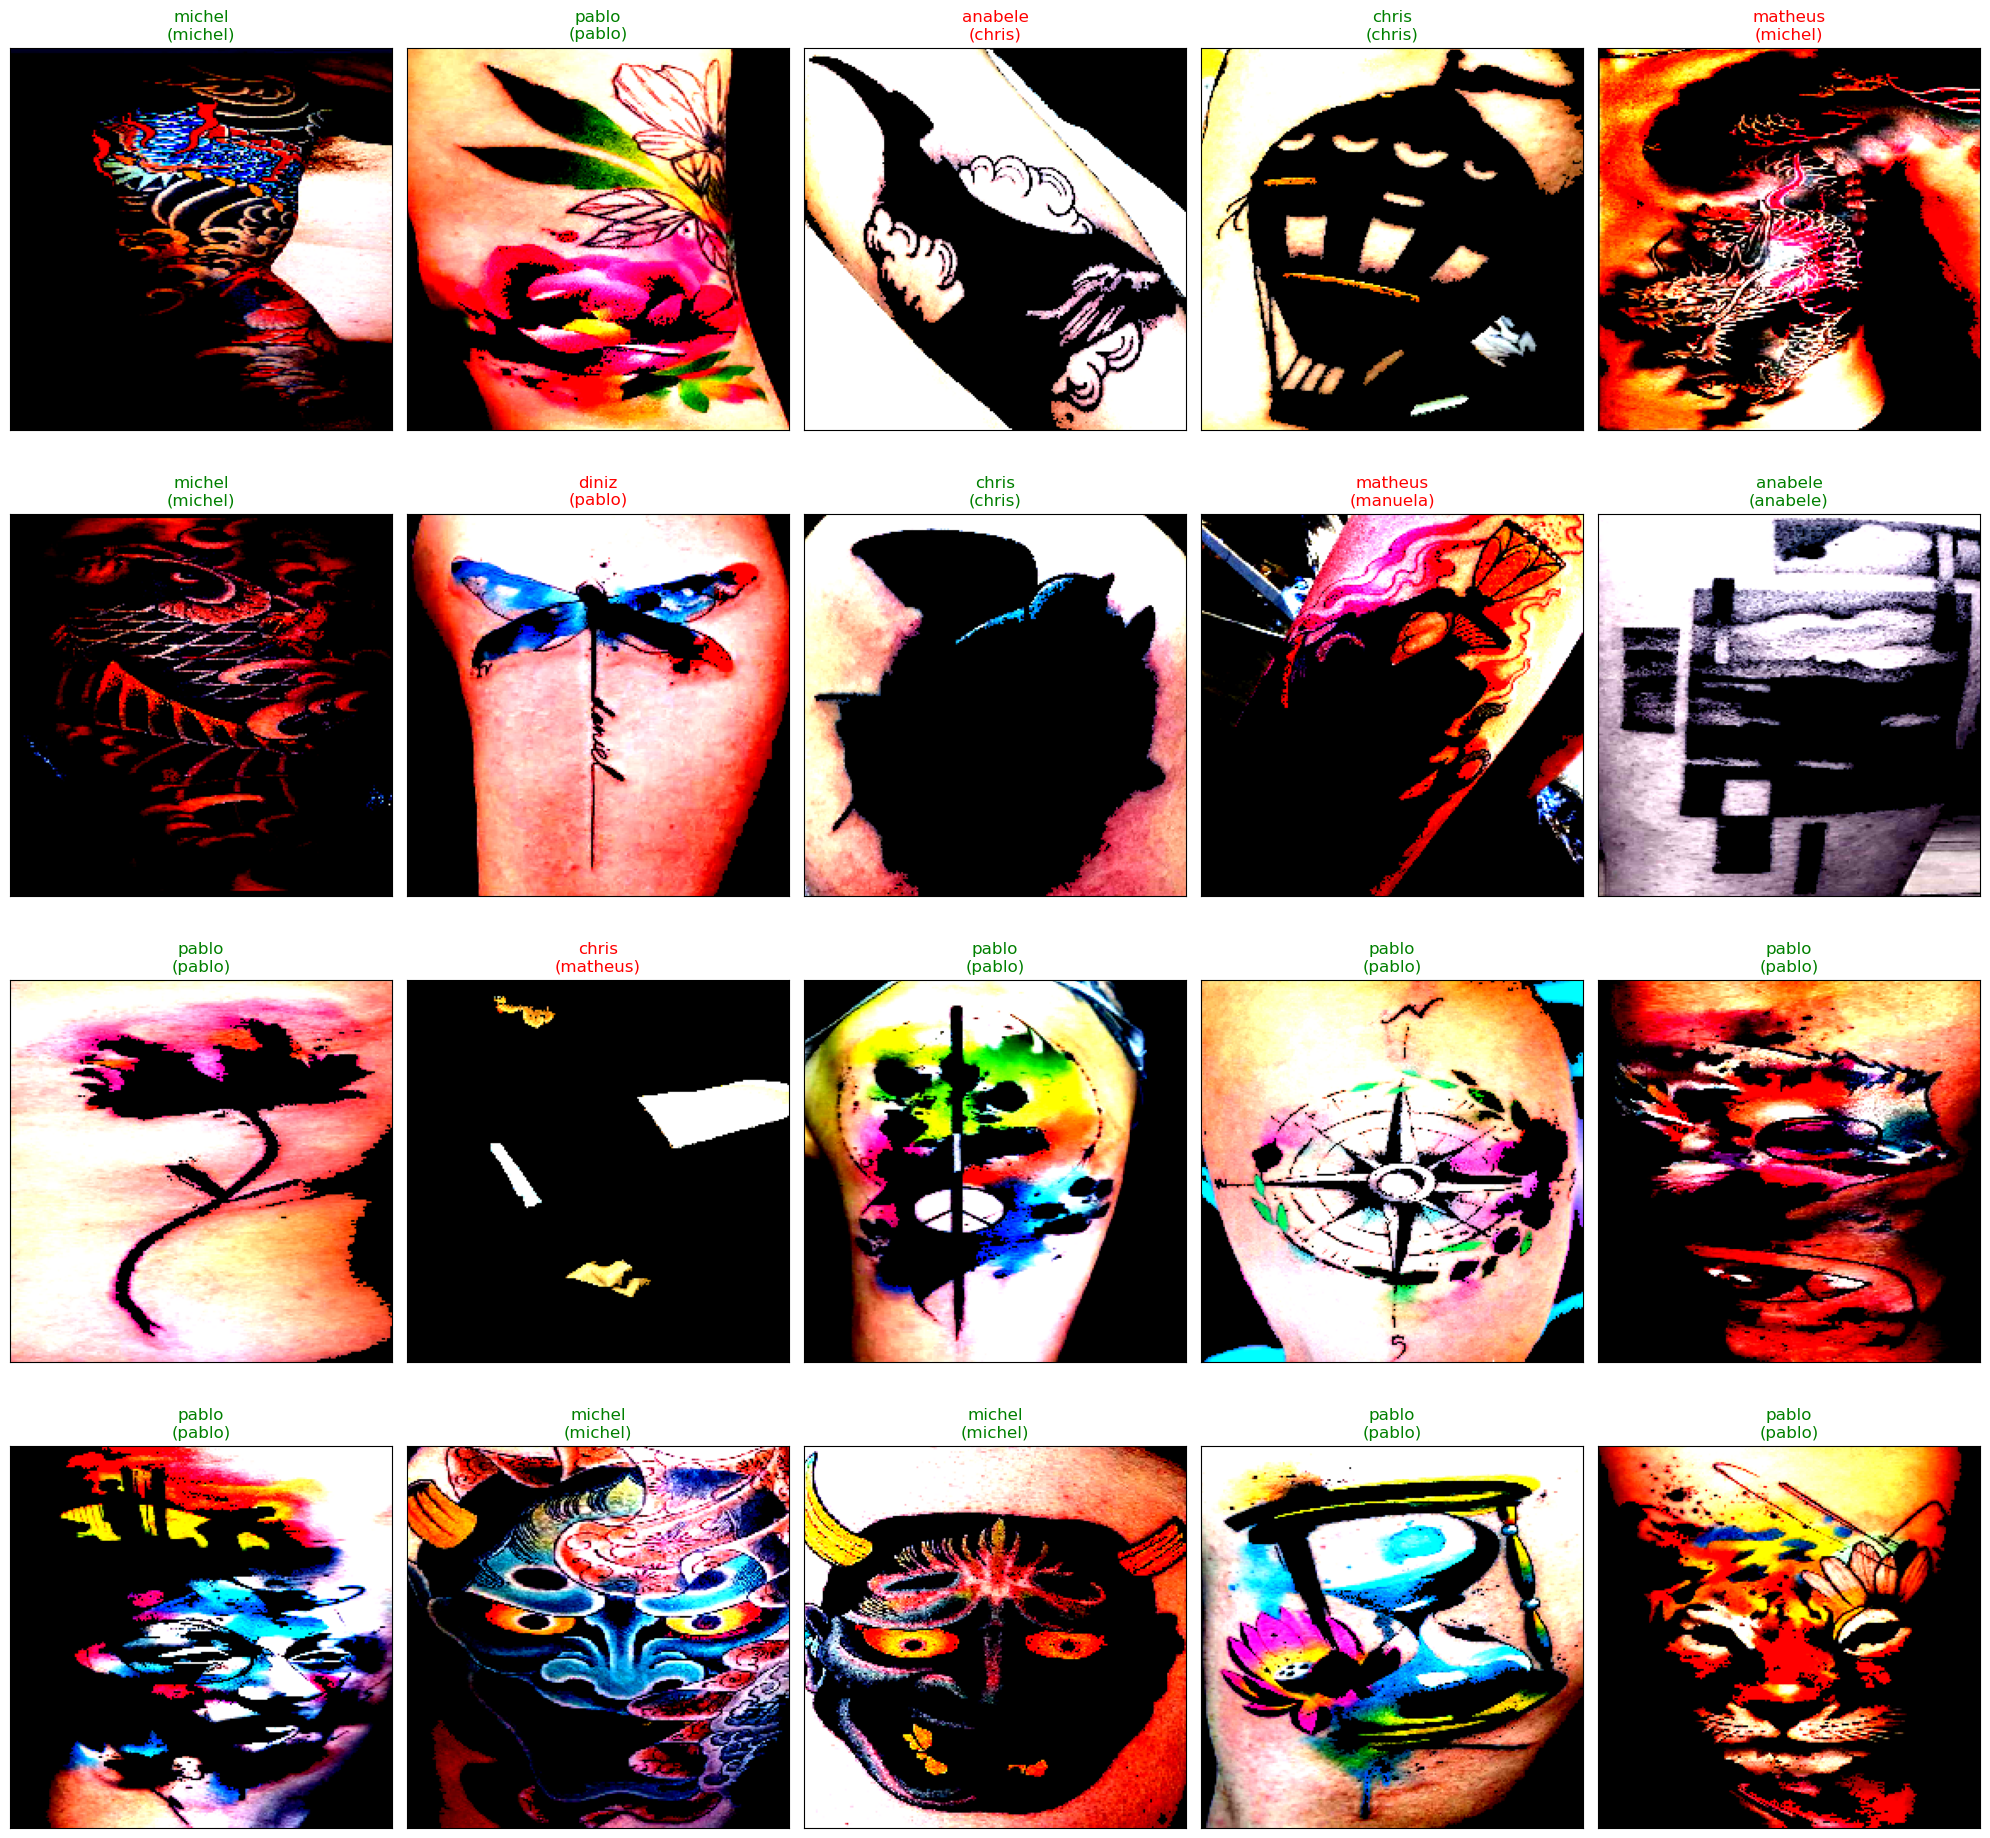

In [20]:
plot_predictions(true_classes, dense_pred_classes, testing, class_indices, 20)

In [55]:
class_names = testing.class_indices.keys()

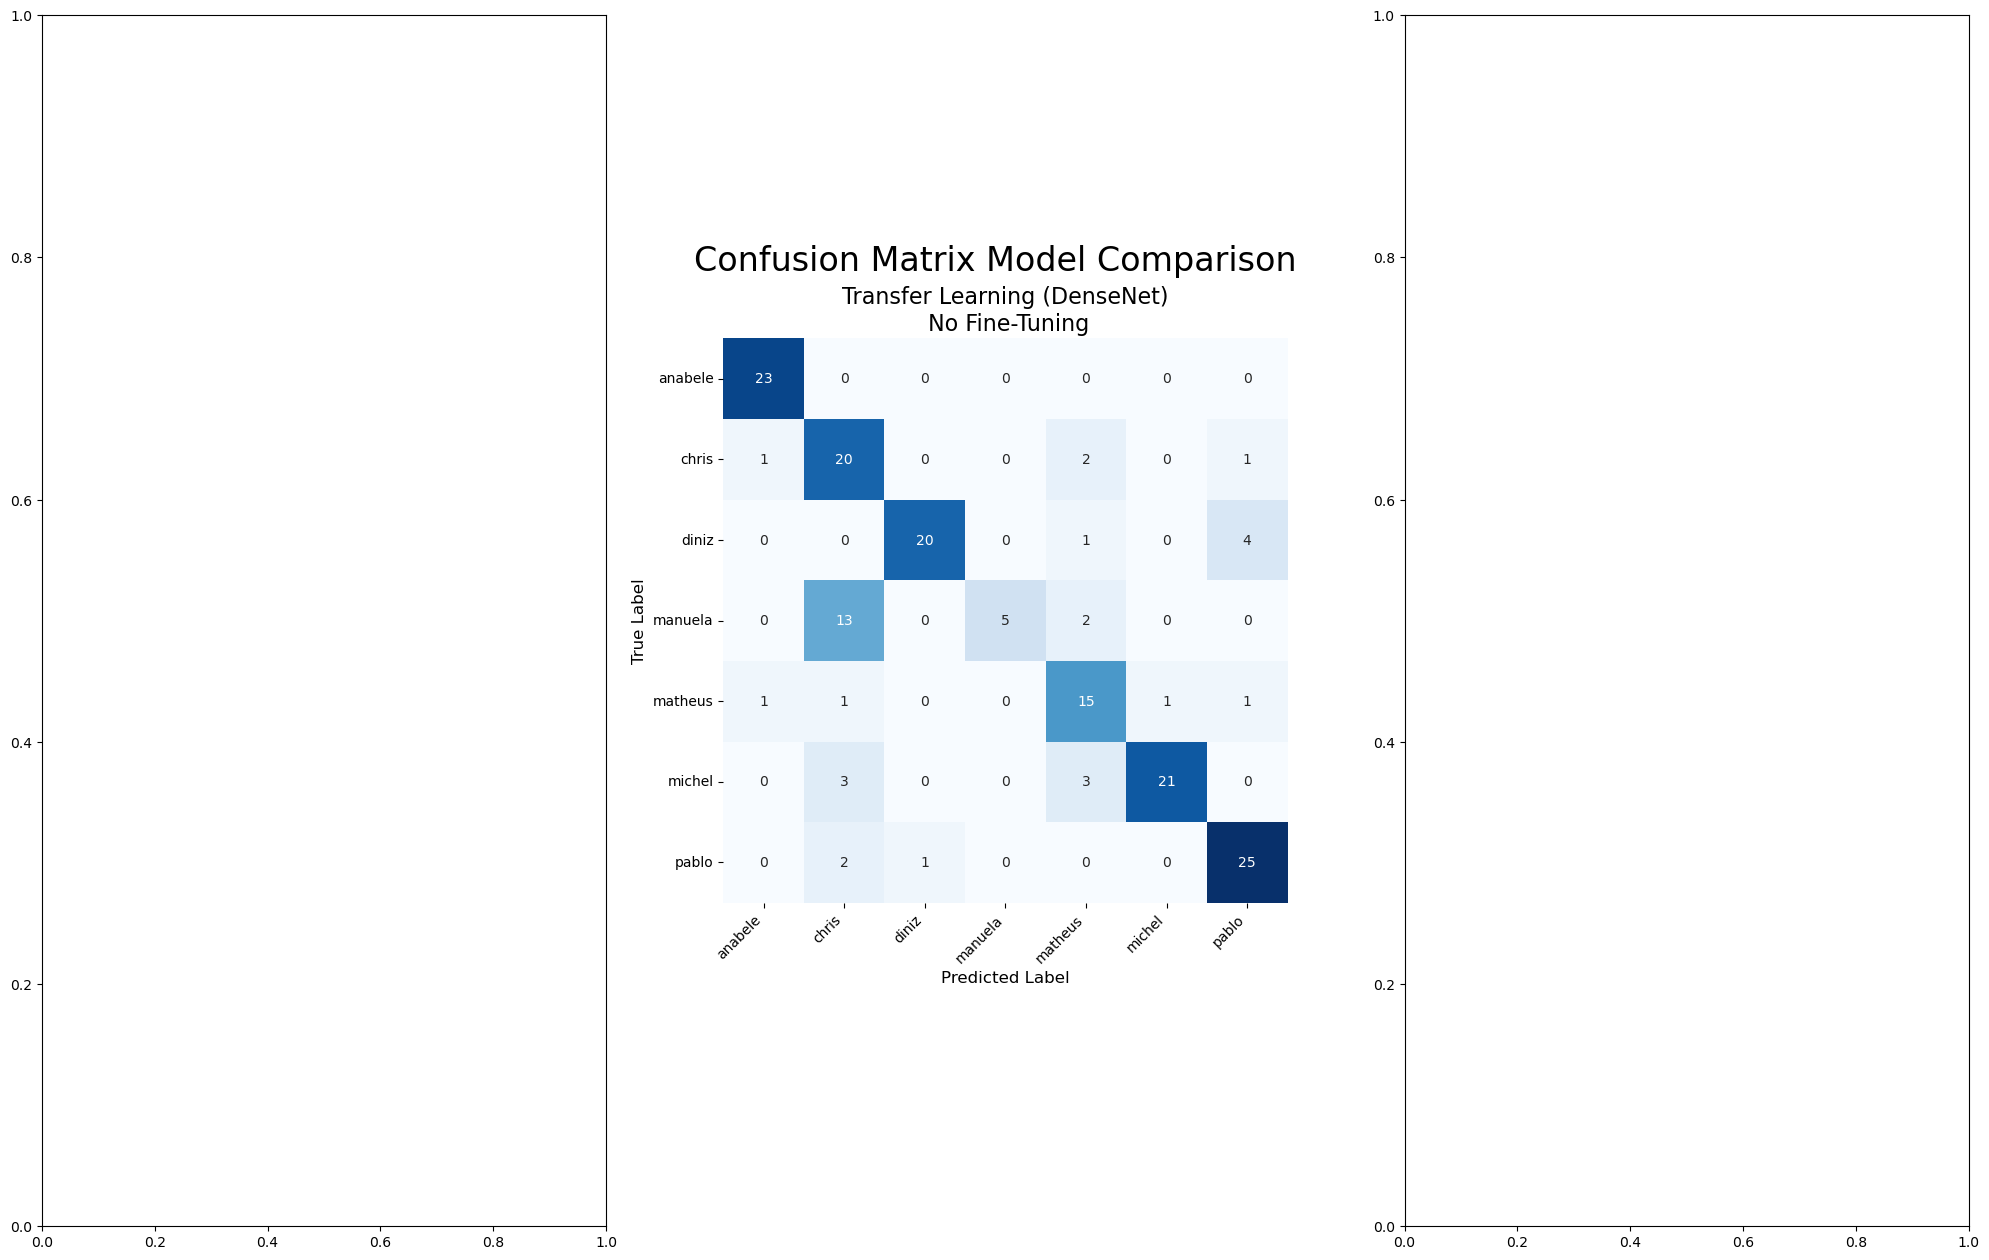

In [56]:
def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true=y_true,
                          y_pred=y_pred,
                          )
    sns.heatmap(cm,
                annot=True,
                square=True,
                xticklabels=class_names,
                yticklabels=class_names,
                fmt='d',
                cmap=plt.cm.Blues,
                cbar=False,
                ax=ax
                )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

#plot_heatmap(true_classes, scratch_pred_classes, class_names, ax1, title="Custom CNN")
#plot_heatmap(true_classes, dense_pred_classes, class_names, ax1, title="Transfer Learning (DenseNet)\n No Fine-Tuning")
plot_heatmap(true_classes, dense_pred_classes, class_names, ax2, title="Transfer Learning (DenseNet)\n No Fine-Tuning")
#plot_heatmap(true_classes, dense_pred_classes, class_names, ax3, title="Transfer Learning (DenseNet)\n No Fine-Tuning")
#plot_heatmap(true_classes, vgg_pred_classes_ft, class_names, ax3, title="Transfer Learning (VGG16) with Fine-Tuning")

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24, y=1.02)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()